# Data Preparation & Function Preparation

### Setting Up Environment


In [1]:
import torch
import torchvision
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt

from pathlib import Path

from torch.utils.data import DataLoader


In [2]:
data_path = Path("DATASET/")

train_image_dir = data_path / "TRAIN"
test_image_dir = data_path / "TEST"

train_image_dir, test_image_dir


(WindowsPath('DATASET/TRAIN'), WindowsPath('DATASET/TEST'))

### Visualize Image

In [3]:
import os

for dirpath, dirname, filename in os.walk(data_path):
    print(dirpath, dirname, len(filename))



DATASET ['TEST', 'TRAIN'] 0
DATASET\TEST ['Organic', 'Recyclable'] 0
DATASET\TEST\Organic [] 1401
DATASET\TEST\Recyclable [] 1112
DATASET\TRAIN ['Organic', 'Recyclable'] 0
DATASET\TRAIN\Organic [] 12565
DATASET\TRAIN\Recyclable [] 9999


In [4]:
import random
from PIL import Image

# Set random seet
image_path_list = list(data_path.glob("*/*/*.jpg"))
image_path_list

sample_path_list = random.sample(image_path_list, k=10)
sample_path_list



[WindowsPath('DATASET/TRAIN/Organic/O_6281.jpg'),
 WindowsPath('DATASET/TRAIN/Organic/O_10353.jpg'),
 WindowsPath('DATASET/TRAIN/Organic/O_5544.jpg'),
 WindowsPath('DATASET/TRAIN/Organic/O_4017.jpg'),
 WindowsPath('DATASET/TRAIN/Recyclable/R_8766.jpg'),
 WindowsPath('DATASET/TRAIN/Organic/O_7482.jpg'),
 WindowsPath('DATASET/TRAIN/Organic/O_5519.jpg'),
 WindowsPath('DATASET/TRAIN/Recyclable/R_6033.jpg'),
 WindowsPath('DATASET/TRAIN/Organic/O_7046.jpg'),
 WindowsPath('DATASET/TRAIN/Organic/O_12441.jpg')]

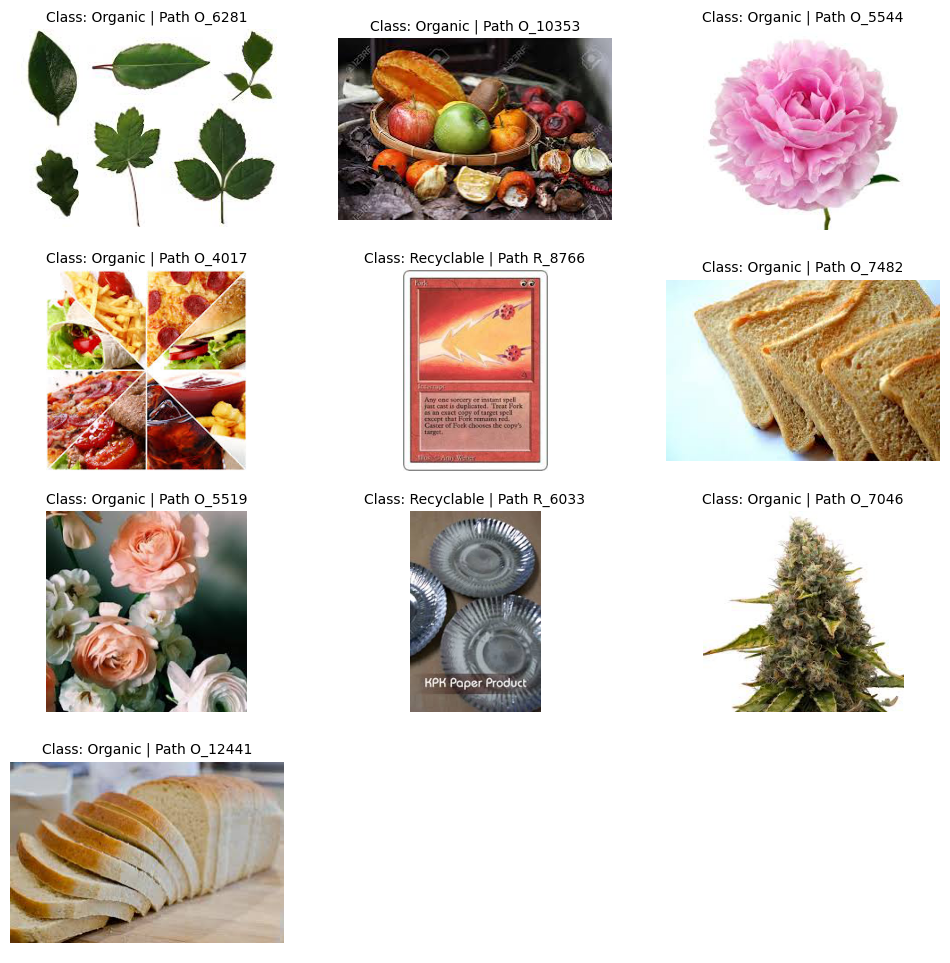

In [5]:
import matplotlib.image as mpimg

def display_image_in_grid(image_paths, grid_size=(4,3)):
    num_images = len(image_paths)
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12,12))

    for i, ax in enumerate(axes.flat):
        ax.axis('off')
        if i < num_images:
            image_path = image_paths[i]
            image = mpimg.imread(image_path)
            ax.imshow(image)
            ax.set_title(f"Class: {image_paths[i].parent.stem} | Path {image_paths[i].stem}", fontsize=10)
        

display_image_in_grid(sample_path_list)

DATASET\TRAIN\Organic\O_6281.jpg
DATASET\TRAIN\Organic\O_10353.jpg
DATASET\TRAIN\Organic\O_5544.jpg
DATASET\TRAIN\Organic\O_4017.jpg
DATASET\TRAIN\Recyclable\R_8766.jpg
DATASET\TRAIN\Organic\O_7482.jpg
DATASET\TRAIN\Organic\O_5519.jpg
DATASET\TRAIN\Recyclable\R_6033.jpg
DATASET\TRAIN\Organic\O_7046.jpg
DATASET\TRAIN\Organic\O_12441.jpg


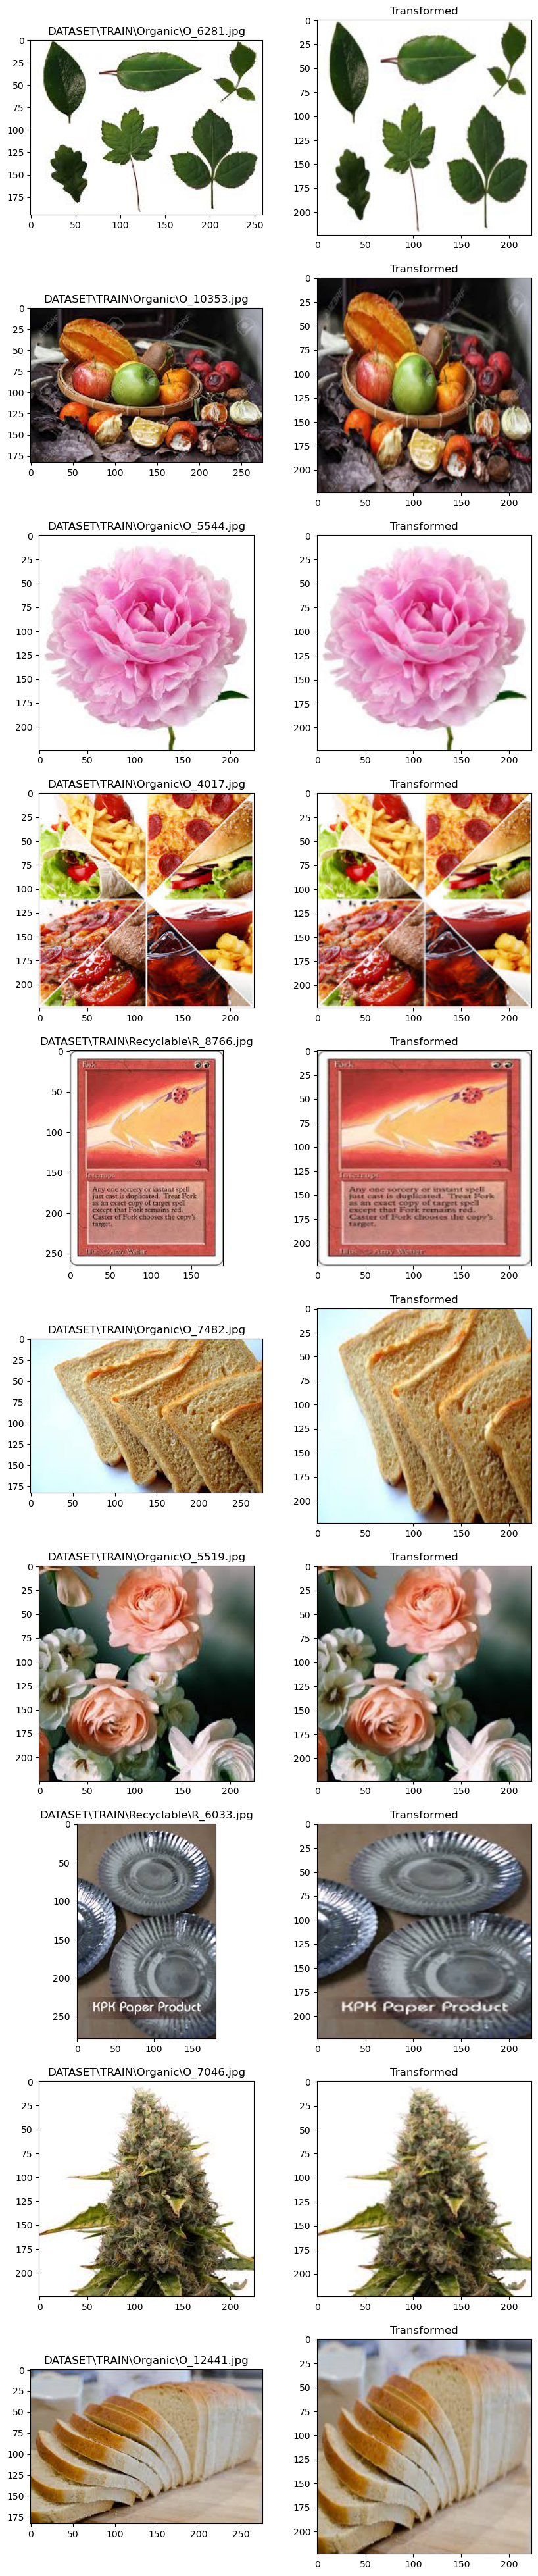

In [6]:
import matplotlib.image as mpimg
from PIL import Image
from torchvision import transforms

image_transform = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

def display_image_before_after_transform(image_paths, transform, grid_size=(10,2)):
    num_images = len(image_paths)
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 5*grid_size[0]))

    for i, ax_row in enumerate(axes):
        image_path = image_paths[i]
        print(image_path)
        for j, ax in enumerate(ax_row):
            # ax.set_title(f"Row: {i} | Col: {j} | Index: {i*2+j}")

            if j == 0:                
                image = mpimg.imread(image_path)
                ax.set_title(f"{image_path}")
                ax.imshow(image)
            else:
                image = Image.open(image_path)
                transformed_image = transform(image).permute(1,2,0) # Convert (C x H x W) to (H x W x C)
                ax.set_title(f"Transformed")
                ax.imshow(transformed_image)        
        

display_image_before_after_transform(sample_path_list, image_transform)

In [7]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_image_dir,
                                 transform=image_transform,
                                 target_transform=None)

test_data = datasets.ImageFolder(root=test_image_dir,
                                transform=image_transform)

train_data

Dataset ImageFolder
    Number of datapoints: 22564
    Root location: DATASET\TRAIN
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [8]:
class_name = train_data.classes
class_name_idx = train_data.class_to_idx

print(class_name, class_name_idx)

['Organic', 'Recyclable'] {'Organic': 0, 'Recyclable': 1}


In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16
NUM_WORKER = 1

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKER)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKER)

### Training Function

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    
    model.train()

    train_loss, train_acc = 0,0

    for batch, (X, y) in enumerate(dataloader):
        
        # Send data to device
        X, y = X.to(device), y.to(device)

        # 1. Forward Pass
        y_pred = model(X)

        # 2. Calculate Function Loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer Zero Grad
        optimizer.zero_grad()

        # 4. Loss Backward
        loss.backward()

        # 5. Optimizer Step
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
    model.eval()

    test_loss, test_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):

        # Send data to device
        X, y = X.to(device), y.to(device)

        # 1. Forward Pass
        test_pred_logits = model(X)

        # 2. Calculate Loss
        loss = loss_fn(test_pred_logits, y)
        test_loss += loss.item()

        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc += (test_pred_labels == y).sum().item() / len(test_pred_logits)

    
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc



In [12]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          device:torch.device,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int=5,
          ):
    
    results = {"train_loss":[],
                 "train_acc": [],
                 "test_loss": [],
                 "test_acc": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

### Evaluation Function

In [13]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from typing import List, Tuple

from PIL import Image

def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):


    # Open image
    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    model.to(device)

    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)



In [28]:
def plot_model_loss_acc(model_results):
    print(model_results)

    print(model_results['train_loss'])
    print(range(len(model_results)))

    num_epoch = range(1, len(model_results['train_loss'])+1)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(num_epoch, model_results['train_loss'], label="Train Loss")
    plt.plot(num_epoch, model_results['test_loss'], label ="Test Loss")
    plt.xlabel("Epoch")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(num_epoch, model_results['train_acc'], label="Train Accuracy")
    plt.plot(num_epoch, model_results['test_acc'], label ="Test Accuracy")
    plt.xlabel("Epoch")
    plt.legend()

# Model And Training

### TinyVGG Architectire

In [15]:
from torch import nn
import torch
class TinyVGGModel0(nn.Module):
    def __init__(self, input_shape: int, hidden_unit: int, output_shape:int) -> None:
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_unit,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit,
                      out_channels=hidden_unit,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1,
                         stride=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_unit,
                      out_channels=hidden_unit,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit,
                      out_channels=hidden_unit,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= hidden_unit * 56 * 56,
                      out_features=output_shape)
        )
    def forward(self, x:torch.Tensor):
        x = self.conv_block1(x)
        # print(x.shape)
        x = self.conv_block2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        
        return x

In [16]:
torch.manual_seed(42)
model_0 = TinyVGGModel0(input_shape=3,
                        hidden_unit=10,
                        output_shape=len(class_name)).to(device)
model_0

TinyVGGModel0(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=2, bias=True)
  )
)

In [17]:
image_batch, label_batch = next(iter(train_dataloader))

image_single, label_single = image_batch[0].unsqueeze(dim=0), label_batch[0]

In [18]:
image_single.shape

torch.Size([1, 3, 224, 224])

In [19]:
y_single = model_0(image_single.to(device))

In [20]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = TinyVGGModel0(input_shape=3,
                        hidden_unit=10,
                        output_shape=len(class_name)).cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

In [21]:
device

'cuda'

In [22]:
from timeit import default_timer as timer

NUM_EPOCHS = 5

start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        device=device,
                        epochs=NUM_EPOCHS)

end_time = timer()

print(f"Total Training Time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4748 | train_acc: 0.7780 | test_loss: 0.3509 | test_acc: 0.8635
Epoch: 2 | train_loss: 0.4381 | train_acc: 0.8028 | test_loss: 0.3600 | test_acc: 0.8734
Epoch: 3 | train_loss: 0.4005 | train_acc: 0.8241 | test_loss: 0.4411 | test_acc: 0.8410
Epoch: 4 | train_loss: 0.3629 | train_acc: 0.8471 | test_loss: 0.4105 | test_acc: 0.8659
Epoch: 5 | train_loss: 0.3302 | train_acc: 0.8630 | test_loss: 0.4744 | test_acc: 0.8576
Total Training Time: 294.399 seconds


In [23]:
torch.save(model_0.state_dict(), "models/TinyVGGModel0.pth")


{'train_loss': [0.4748026041550302, 0.4381279565980044, 0.4004583872226347, 0.3628980271586875, 0.3301576412474957], 'train_acc': [0.777950035435861, 0.8028437278525868, 0.8241052445074415, 0.8470942593905032, 0.86299610205528], 'test_loss': [0.3508682365564606, 0.3599752833288682, 0.4410916080910571, 0.4104836338753753, 0.4744154055237393], 'test_acc': [0.8635284810126582, 0.8734177215189873, 0.8409810126582279, 0.8659018987341772, 0.8575949367088608]}
[0.4748026041550302, 0.4381279565980044, 0.4004583872226347, 0.3628980271586875, 0.3301576412474957]
range(0, 4)


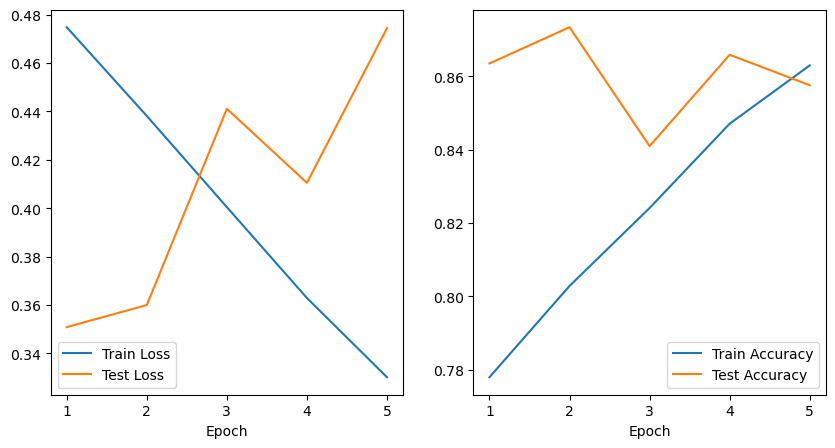

In [43]:
plot_model_loss_acc(model_0_results)

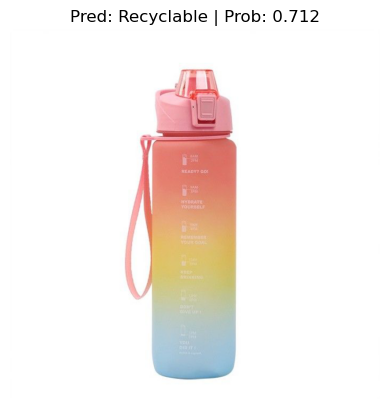

In [25]:
pred_and_plot_image(model=model_0, transform=image_transform, image_path="test_image.jpg", device=device, class_names = class_name)

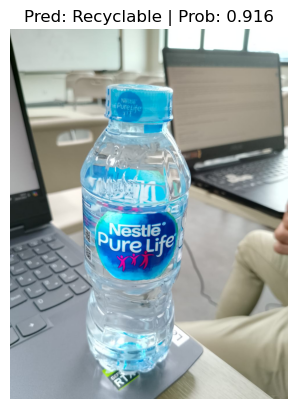

In [26]:
pred_and_plot_image(model=model_0, transform=image_transform, image_path="test_image_2.jpeg", device=device, class_names = class_name)

### Efficient Architecture (Transfer Learning)

In [60]:
from torchvision import transforms
efficient_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.299, 0.224, 0.225])
])

In [61]:
from torch.utils.data import DataLoader
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_image_dir,
                                 transform=efficient_transform,
                                 target_transform=None)

test_data = datasets.ImageFolder(root=test_image_dir,
                                transform=efficient_transform)


BATCH_SIZE = 20
NUM_WORKER = 1

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKER)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKER)

In [73]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT 
model_1 = torchvision.models.efficientnet_b0(weights=weights)

In [74]:
from torchinfo import summary

summary(model=model_1,
        input_size=(20,3,224, 224),
        col_names = ["input_size","output_size","num_params","trainable"],
        col_width = 20,
        row_settings=["var_names"]    
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [20, 3, 224, 224]    [20, 1000]           --                   True
├─Sequential (features)                                      [20, 3, 224, 224]    [20, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [20, 3, 224, 224]    [20, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [20, 3, 224, 224]    [20, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [20, 32, 112, 112]   [20, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [20, 32, 112, 112]   [20, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [20, 32, 112, 112]   [20, 16, 112

In [75]:
# Freeze Parameter except classification
for param in model_1.features.parameters():
    param.requires_grad = False

In [76]:
# Set Manual Seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length
output_shape = len(class_name)

# Override classifier layer
model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True).to(device)
)

In [77]:
from torchinfo import summary

summary(model=model_1,
        input_size=(20,3,224, 224),
        col_names = ["input_size","output_size","num_params","trainable"],
        col_width = 20,
        row_settings=["var_names"]    
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [20, 3, 224, 224]    [20, 2]              --                   Partial
├─Sequential (features)                                      [20, 3, 224, 224]    [20, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [20, 3, 224, 224]    [20, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [20, 3, 224, 224]    [20, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [20, 32, 112, 112]   [20, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [20, 32, 112, 112]   [20, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [20, 32, 112, 112]   [20, 

In [78]:
from torch import nn
import torch


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

In [79]:
# Train Model



from timeit import default_timer as timer
start_time = timer()

model_1_results = train(model=model_1,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=5,
      device=device)
end_time = timer()

print(f"[INFO] Total Training Time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2764 | train_acc: 0.8903 | test_loss: 0.2403 | test_acc: 0.9111
Epoch: 2 | train_loss: 0.2408 | train_acc: 0.9057 | test_loss: 0.2648 | test_acc: 0.9005
Epoch: 3 | train_loss: 0.2429 | train_acc: 0.9057 | test_loss: 0.2180 | test_acc: 0.9226
Epoch: 4 | train_loss: 0.2411 | train_acc: 0.9052 | test_loss: 0.2998 | test_acc: 0.8795
Epoch: 5 | train_loss: 0.2381 | train_acc: 0.9089 | test_loss: 0.2038 | test_acc: 0.9267
[INFO] Total Training Time: 306.541 seconds


{'train_loss': [0.2764376111335201, 0.2408048640128202, 0.2428622636185139, 0.24107137053340436, 0.23809775841761416], 'train_acc': [0.8903454384411007, 0.9056687333923855, 0.9057130203720134, 0.9051815766164767, 0.9088573959255998], 'test_loss': [0.24034366159448547, 0.26475407847661586, 0.21799889125580352, 0.29975240237434353, 0.20377277296095614], 'test_acc': [0.9110500610500616, 0.9005494505494507, 0.9225885225885231, 0.8795177045177047, 0.9267399267399276]}
[0.4748026041550302, 0.4381279565980044, 0.4004583872226347, 0.3628980271586875, 0.3301576412474957]
range(0, 4)


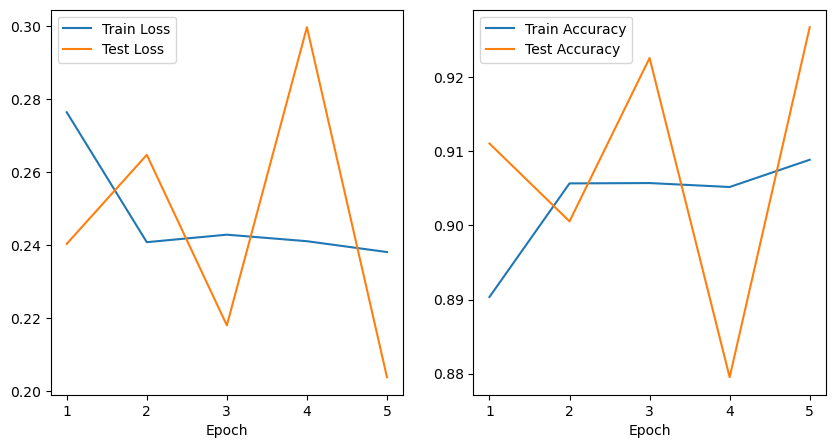

In [80]:
plot_model_loss_acc(model_1_results)

In [81]:
torch.save(model_1.state_dict(), "models/EfficientModel1.pth")


### Efficient Model (Transfer Learning) Data Augmentation

In [15]:
from torchvision import transforms
efficient_augment_transform = transforms.Compose([
    transforms.TrivialAugmentWide(num_magnitude_bins=42),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.299, 0.224, 0.225])
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

DATASET\TRAIN\Organic\O_6281.jpg
DATASET\TRAIN\Organic\O_10353.jpg
DATASET\TRAIN\Organic\O_5544.jpg
DATASET\TRAIN\Organic\O_4017.jpg
DATASET\TRAIN\Recyclable\R_8766.jpg
DATASET\TRAIN\Organic\O_7482.jpg
DATASET\TRAIN\Organic\O_5519.jpg
DATASET\TRAIN\Recyclable\R_6033.jpg
DATASET\TRAIN\Organic\O_7046.jpg
DATASET\TRAIN\Organic\O_12441.jpg


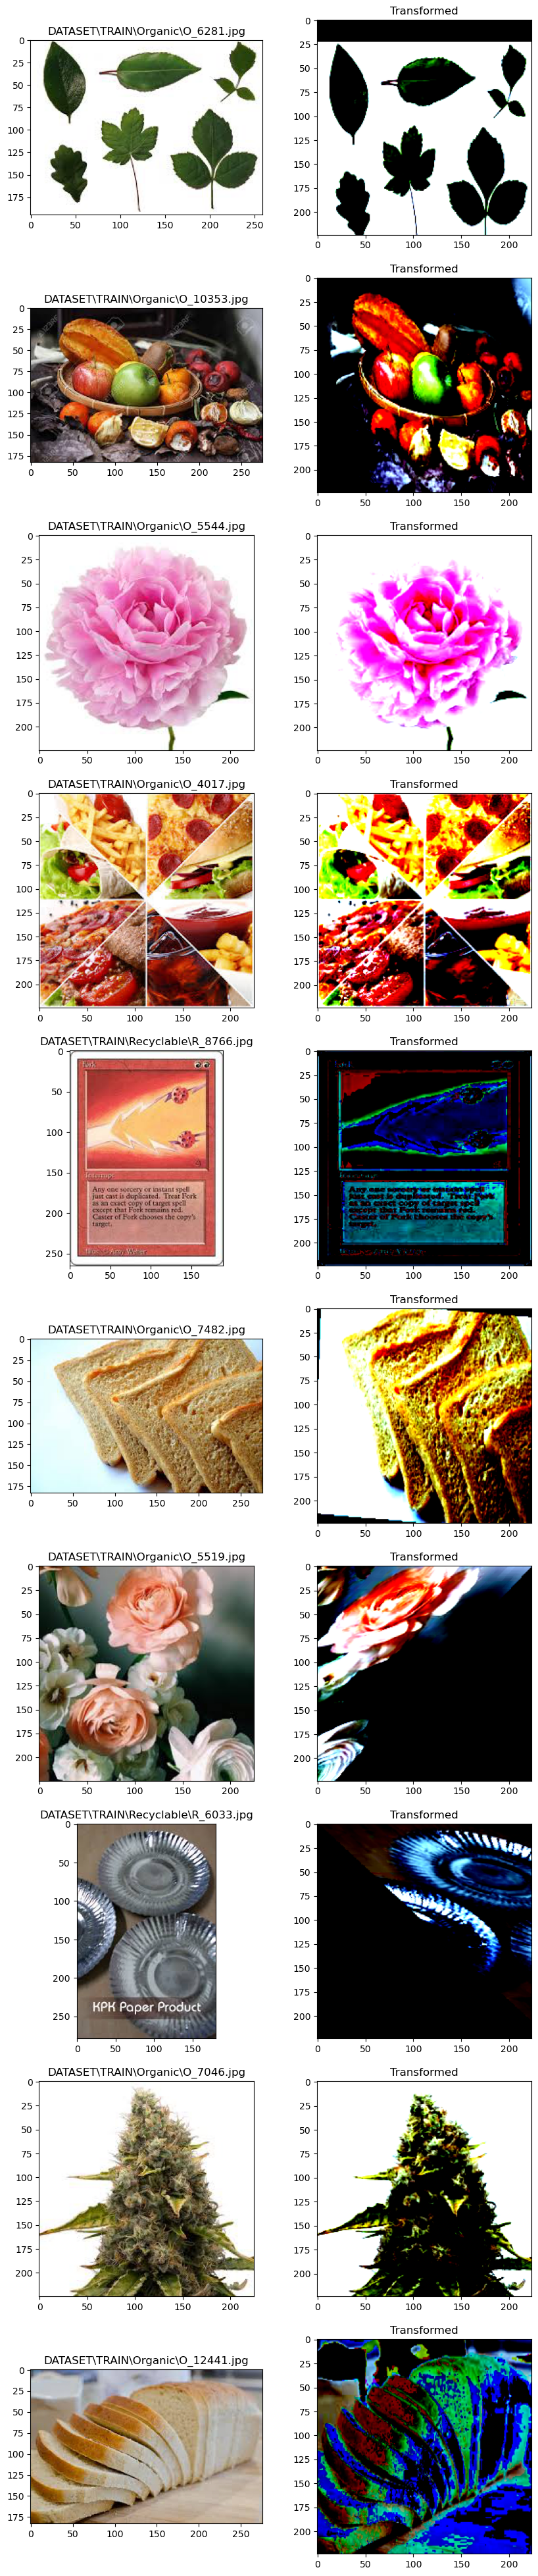

In [16]:
display_image_before_after_transform(sample_path_list, efficient_augment_transform)

In [17]:
from torch.utils.data import DataLoader
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_image_dir,
                                 transform=efficient_augment_transform,
                                 target_transform=None)

test_data = datasets.ImageFolder(root=test_image_dir,
                                transform=efficient_augment_transform)


BATCH_SIZE = 20
NUM_WORKER = 1

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKER)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKER)

In [20]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT 
model_2 = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [21]:
# Freeze Parameter except classification
for param in model_2.features.parameters():
    param.requires_grad = False

In [22]:
# Set Manual Seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length
output_shape = len(class_name)

# Override classifier layer
model_2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True).to(device)
)

In [23]:
device

'cuda'

In [24]:
from torch import nn
import torch


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)

In [25]:
# Train Model

from timeit import default_timer as timer
start_time = timer()

model_2_results = train(model=model_2,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=5,
      device=device)
end_time = timer()

print(f"[INFO] Total Training Time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3063 | train_acc: 0.8757 | test_loss: 0.2447 | test_acc: 0.9063
Epoch: 2 | train_loss: 0.2758 | train_acc: 0.8908 | test_loss: 0.2342 | test_acc: 0.9131
Epoch: 3 | train_loss: 0.2709 | train_acc: 0.8925 | test_loss: 0.2545 | test_acc: 0.8958
Epoch: 4 | train_loss: 0.2722 | train_acc: 0.8902 | test_loss: 0.3047 | test_acc: 0.8757
Epoch: 5 | train_loss: 0.2683 | train_acc: 0.8921 | test_loss: 0.2674 | test_acc: 0.8940
[INFO] Total Training Time: 367.759 seconds


{'train_loss': [0.3062965088681482, 0.2758185359277326, 0.270948421833682, 0.27221911774075486, 0.2683286035550549], 'train_acc': [0.8757307351638631, 0.8908325952170075, 0.8924712134632447, 0.8902125775022155, 0.892116917626221], 'test_loss': [0.24473383055911177, 0.2342294683857333, 0.25446924758661127, 0.3046805930013458, 0.2673914695956877], 'test_acc': [0.9063186813186818, 0.9130647130647137, 0.8957875457875463, 0.8757326007326008, 0.8939865689865694]}
[0.3062965088681482, 0.2758185359277326, 0.270948421833682, 0.27221911774075486, 0.2683286035550549]
range(0, 4)


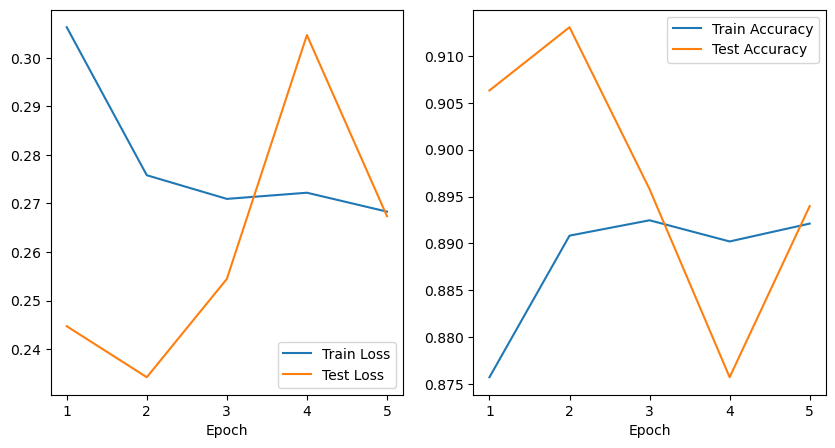

In [29]:
plot_model_loss_acc(model_2_results)

In [30]:
torch.save(model_2.state_dict(), "models/EfficientModelAugmented2.pth")


### Efficientb2 Model (Transfer Learning)

In [33]:
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT 
model_3 = torchvision.models.efficientnet_b2(weights=weights).to(device)

In [34]:
from torchvision import transforms
efficient_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.299, 0.224, 0.225])
])

from torch.utils.data import DataLoader
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_image_dir,
                                 transform=efficient_transform,
                                 target_transform=None)

test_data = datasets.ImageFolder(root=test_image_dir,
                                transform=efficient_transform)


BATCH_SIZE = 20
NUM_WORKER = 1

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKER)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKER)

In [35]:
from torchinfo import summary

summary(model=model_3,
        input_size=(20,3,224, 224),
        col_names = ["input_size","output_size","num_params","trainable"],
        col_width = 20,
        row_settings=["var_names"]    
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [20, 3, 224, 224]    [20, 1000]           --                   True
├─Sequential (features)                                      [20, 3, 224, 224]    [20, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [20, 3, 224, 224]    [20, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [20, 3, 224, 224]    [20, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [20, 32, 112, 112]   [20, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [20, 32, 112, 112]   [20, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [20, 32, 112, 112]   [20, 16, 112

In [36]:
# Freeze Parameter except classification
for param in model_3.features.parameters():
    param.requires_grad = False



In [37]:
# Set Manual Seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length
output_shape = len(class_name)

# Override classifier layer
model_3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1408,
                    out_features=output_shape,
                    bias=True).to(device)
)

In [38]:
from torch import nn
import torch


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_3.parameters(), lr=0.001)

In [39]:
# Train Model

from timeit import default_timer as timer
start_time = timer()

model_3_results = train(model=model_3,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=5,
      device=device)
end_time = timer()

print(f"[INFO] Total Training Time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
plot_model_loss_acc(model_results=model_3_results)

# Load Model